In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time
import os
import sys
sys.path.append('../../')

from data.processing import get_data

import models

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new
from main.seir.sensitivity import calculate_sensitivity_and_plot
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
#from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles, plot_ptiles_comp
from viz.fit import plot_all_losses

import yaml

In [3]:
from os.path import exists, join, splitext

In [4]:
import pickle as pkl
with open('../../misc/predictions/final_mumbai_20.pickle', 'rb') as handle:
    PD = pkl.load(handle)

FileNotFoundError: [Errno 2] No such file or directory: '../../misc/predictions/final_mumbai_20.pickle'

In [5]:
config_filename = 'default.yaml'
config = read_config(config_filename)

In [6]:
import matplotlib as mpl
## for Palatino and other serif fonts use:
plt.rcParams.update({
    'font.size': 12,
 })

total


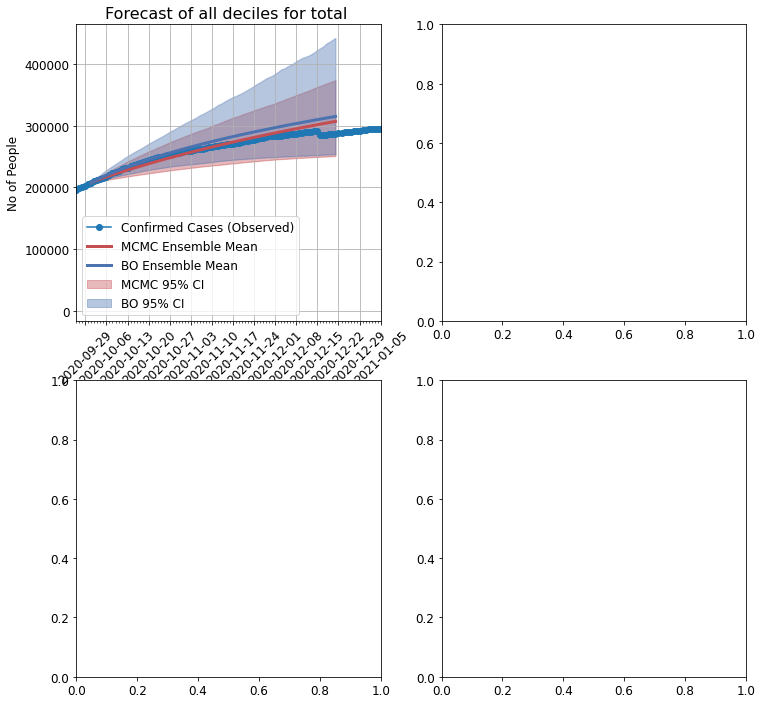

In [7]:
fig,axs = plt.subplots(figsize=(12,12),nrows=2,ncols=2) 
plot_ptiles_comp(PD['m1'], compartment=config['forecast']['plot_ptiles_for_columns'][0],ax=axs.flat[0])
fig.savefig('/Users/avtansht/Desktop/Desktop/Wadhwani/Plots_final/CI.pdf',  format='pdf', bbox_inches='tight', pad_inches=0)

In [8]:
import pandas as pd
PD['m0']['MCMC']['ensemble_mean_forecast']['df_prediction'].keys()

Index(['date', 'total', 'recovered', 'active', 'deceased'], dtype='object')

In [9]:
which_compartments = ['total', 'active', 'recovered', 'deceased','agg']

In [10]:
df_compiled = {"MCMC":[],"BO":[]}
for run,run_dict in PD.items():
    for model,model_dict in run_dict.items():
        df = model_dict['m1']['df_loss']['train']
        df['agg'] = df.mean()
        df_compiled[model].append(df)
        

In [11]:
np.linspace(0,100,42)

array([  0.        ,   2.43902439,   4.87804878,   7.31707317,
         9.75609756,  12.19512195,  14.63414634,  17.07317073,
        19.51219512,  21.95121951,  24.3902439 ,  26.82926829,
        29.26829268,  31.70731707,  34.14634146,  36.58536585,
        39.02439024,  41.46341463,  43.90243902,  46.34146341,
        48.7804878 ,  51.2195122 ,  53.65853659,  56.09756098,
        58.53658537,  60.97560976,  63.41463415,  65.85365854,
        68.29268293,  70.73170732,  73.17073171,  75.6097561 ,
        78.04878049,  80.48780488,  82.92682927,  85.36585366,
        87.80487805,  90.24390244,  92.68292683,  95.12195122,
        97.56097561, 100.        ])

In [12]:
df_compiled['MCMC'][0]

total        0.493634
active        3.82129
recovered    0.686175
deceased     0.356793
agg           1.33947
Name: train, dtype: object

In [13]:
import pandas as pd
from viz.fit import comp_bar

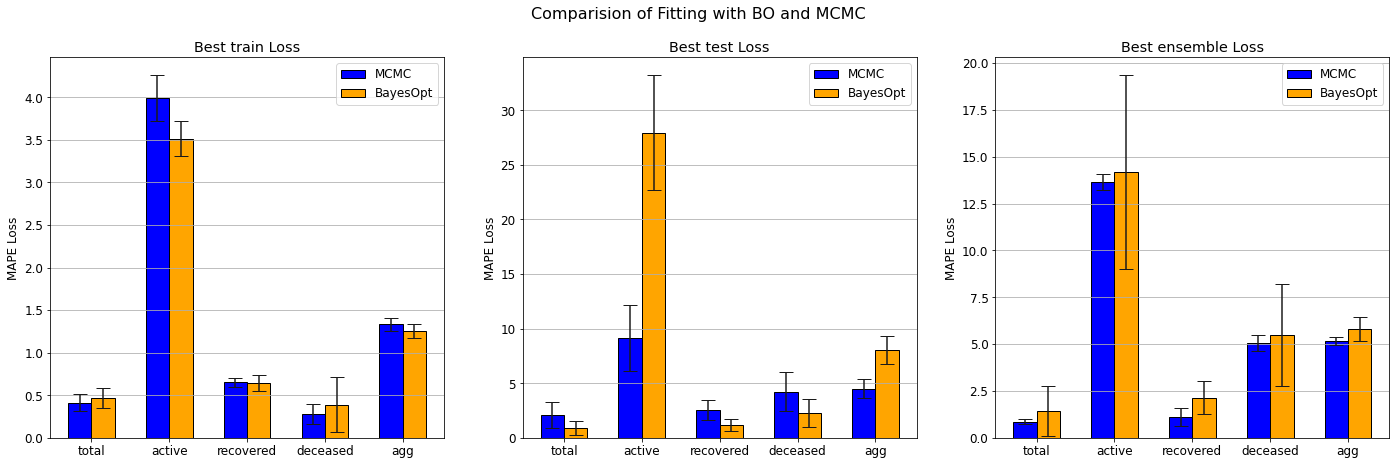

In [14]:
fig,axs = plt.subplots(figsize=(24,7),nrows=1,ncols=3)
comp_bar(PD,'train',axs.flat[0])
comp_bar(PD,'test',axs.flat[1])
comp_bar(PD,'ensemble',axs.flat[2])
fig.suptitle('Comparision of Fitting with BO and MCMC', fontsize=16)
fig.savefig('/Users/avtansht/Desktop/Desktop/Wadhwani/Plots_final/Bar_plots.pdf',  format='pdf', bbox_inches='tight', pad_inches=0)

## Comparing best loss from MCMC vs BO

In [19]:
import numpy as np
import matplotlib.pyplot as plt
barWidth = 0.3

plt.figure(figsize=(12,8))
# Choose the height of the blue bars
bars1 = stats['MCMC'].loc[['mean']].values[0]
 
# Choose the height of the cyan bars
bars2 = stats['BO'].loc[['mean']].values[0]
 
# Choose the height of the error bars (bars1)
yer1 = stats['MCMC'].loc[['std']].values[0]
 
# Choose the height of the error bars (bars2)
yer2 = stats['BO'].loc[['std']].values[0]
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='MCMC')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'orange', edgecolor = 'black', yerr=yer2, capsize=7, label='BayesOpt')
 
# general layout
plt.grid(b = True,axis = 'y')
plt.xticks([r + barWidth/2 for r in range(len(bars1))], which_compartments)
plt.ylabel('MAPE_Loss')
plt.title('Best Train Loss 1 November - 21 November')
plt.legend()
 
# Show graphic
plt.show()


NameError: name 'stats' is not defined

<Figure size 864x576 with 0 Axes>

## Comparing Ensemble loss from MCMC vs BO

In [20]:
PD['m0']['MCMC']['ensemble_mean_forecast']['df_loss']

{'active': 13.743454828650881,
 'recovered': 1.8885542192453262,
 'deceased': 4.517441675103834,
 'total': 0.9546463642942944,
 'agg': 5.276024271823585}

In [21]:
df_compiled_ens = {"MCMC":[],"BO":[]}
for run,run_dict in PD.items():
    for model,model_dict in run_dict.items():
        df = model_dict['ensemble_mean_forecast']['df_loss']
        df['agg'] = np.mean(list(df.values()))
        df2 = {comp:df[comp] for comp in which_compartments}
        df_compiled_ens[model].append(df2)

In [22]:
import pandas as pd
stats_ens = {}
stats_ens['MCMC'] = (pd.DataFrame(df_compiled_ens['MCMC']).describe()).loc[['mean','std']]
stats_ens['BO'] = (pd.DataFrame(df_compiled_ens['BO']).describe()).loc[['mean','std']]

In [23]:
pd.DataFrame(df_compiled_ens['BO'])

,total,active,recovered,deceased,agg
0,0.474246,16.290626,1.347314,6.158284,6.067617
1,3.337183,7.411510,3.220335,6.630964,5.149998
2,4.031874,6.053560,3.783674,11.007754,6.219216
3,1.795500,11.100641,2.587256,3.803031,4.821607
4,1.595504,11.884435,2.256751,7.315839,5.763132
5,0.714989,13.693565,1.542450,4.131737,5.020685
6,0.169409,21.865406,1.297012,4.127652,6.864870
7,1.359748,16.041842,2.316869,5.954557,6.418254
8,0.514224,20.304475,1.886100,0.617280,5.830520
9,0.221459,17.085739,1.158017,5.121148,5.896591


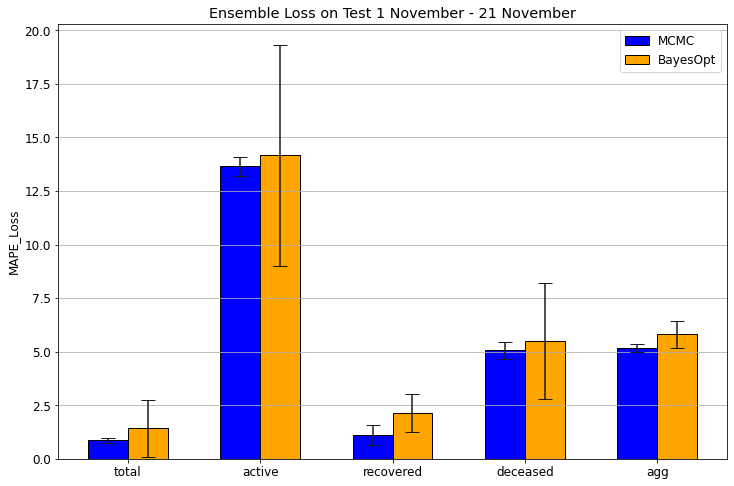

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
barWidth = 0.3

plt.figure(figsize=(12,8))
# Choose the height of the blue bars
bars1 = stats_ens['MCMC'].loc[['mean']].values[0]
 
# Choose the height of the cyan bars
bars2 = stats_ens['BO'].loc[['mean']].values[0]
 
# Choose the height of the error bars (bars1)
yer1 = stats_ens['MCMC'].loc[['std']].values[0]
 
# Choose the height of the error bars (bars2)
yer2 = stats_ens['BO'].loc[['std']].values[0]
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='MCMC')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'orange', edgecolor = 'black', yerr=yer2, capsize=7, label='BayesOpt')
 
# general layout
plt.grid(b = True,axis = 'y')
plt.xticks([r + barWidth/2 for r in range(len(bars1))], which_compartments)
plt.ylabel('MAPE_Loss')
plt.title('Ensemble Loss on Test 1 November - 21 November')
plt.legend()
 
# Show graphic
plt.show()

## DIC 

In [ ]:
df_compiled_DIC = {"MCMC":[],"BO":[]}
for run,run_dict in PD.items():
    for model,model_dict in run_dict.items():
        df = model_dict['m1']['metric']['DIC']
        df_compiled_DIC[model].append(df)
df_compiled_DIC

In [ ]:
barWidth = 0.3
plt.figure(figsize=(10,13))
# Choose the height of the blue bars
bars1 = [np.mean(df_compiled_DIC['MCMC'])]
 
# Choose the height of the cyan bars
bars2 = [np.mean(df_compiled_DIC['BO'])]
 
# Choose the height of the error bars (bars1)
yer1 = [np.std(df_compiled_DIC['MCMC'])]
 
# Choose the height of the error bars (bars2)
yer2 = [np.std(df_compiled_DIC['BO'])]
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='MCMC')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'orange', edgecolor = 'black', yerr=yer2, capsize=7, label='BayesOpt')
 
# general layout
plt.grid(b = True,axis = 'y')
plt.xticks([r + barWidth/2 for r in range(len(bars1))], ['MCMC                                    BO'])
plt.ylabel('DIC')
plt.title('DIC Values on Train for 25 Aug to 16 Sep')
plt.legend()
 
# Show graphic
plt.show()

## Percentile Loss

In [25]:
PD['m0']['MCMC']['uncertainty_forecasts'].keys()

dict_keys([2.5, 5.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 95.0, 97.5])

In [26]:
df_compiled_perc_loss = {"MCMC":[],"BO":[]}
percentiles = []

for run,run_dict in PD.items():
    for model,model_dict in run_dict.items():
        df = {}
        percentiles = list(model_dict['uncertainty_forecasts'].keys())
        for perc,perc_dict in model_dict['uncertainty_forecasts'].items():
            df[perc] = perc_dict['df_loss_perc']['test']['total']
        df_compiled_perc_loss[model].append(df)

In [27]:
pd.DataFrame(df_compiled_perc_loss['MCMC'])

,2.5,5.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0,95.0,97.5
0,0.331409,0.575204,0.943119,1.277673,1.319642,1.148399,0.509379,0.399510,0.776173,0.901521,0.742351,0.515582,0.318987
1,0.286637,0.498855,0.785733,1.073054,1.049428,0.751686,0.374643,0.624098,0.933891,1.038050,0.831534,0.559028,0.326594
2,0.261238,0.452023,0.706270,0.906334,0.769321,0.423011,0.497043,0.788087,1.121290,1.185644,0.870456,0.576826,0.378620
3,0.325468,0.545448,0.803923,1.032661,0.942227,0.553420,0.390791,0.644687,0.997712,1.092300,0.876672,0.614567,0.382484
4,0.309690,0.532322,0.836395,1.129168,1.082273,0.752850,0.399975,0.596652,0.930730,1.080735,0.828512,0.524244,0.328207
5,0.321816,0.544697,0.838630,1.166660,1.123713,0.842808,0.426812,0.469881,0.837924,0.992542,0.822528,0.556478,0.344190
6,0.303929,0.532347,0.851171,1.219175,1.253277,0.956425,0.490323,0.454243,0.844717,0.984212,0.774726,0.516237,0.326145
7,0.360488,0.628768,1.036720,1.401683,1.391122,0.942100,0.386853,0.636472,1.058611,1.163804,0.902265,0.580483,0.331954
8,0.271698,0.451439,0.706035,0.898541,0.738744,0.395541,0.497339,0.847424,1.132805,1.133539,0.849651,0.550247,0.342767
9,0.350619,0.604172,0.927127,1.166750,1.069471,0.731456,0.405148,0.579244,0.909686,1.063515,0.855008,0.551583,0.334107


In [28]:
stats_perc_MCMC = pd.DataFrame(df_compiled_perc_loss['MCMC']).describe().loc[['mean','std']]
stats_perc_BO = pd.DataFrame(df_compiled_perc_loss['BO']).describe().loc[['mean','std']]

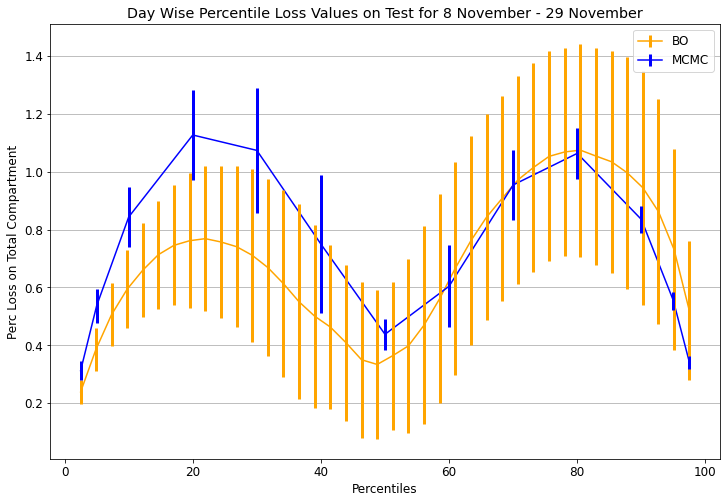

In [29]:
import matplotlib as mpl
barWidth = 0.3

plt.figure(figsize=(12,8))
plt.errorbar(list(stats_perc_BO.loc['mean'].keys()),list(stats_perc_BO.loc['mean'].values),color = 'orange',label='BO',yerr =list(stats_perc_BO.loc['std'].values) ,elinewidth =3,capthick =3,barsabove = True)
plt.errorbar(list(stats_perc_MCMC.loc['mean'].keys()),list(stats_perc_MCMC.loc['mean'].values),color = 'blue',label = 'MCMC',yerr = list(stats_perc_MCMC.loc['std'].values),elinewidth =3,capthick =3,barsabove = True)


# general layout
plt.grid(b = True,axis = 'y')
plt.ylabel('Perc Loss on Total Compartment')
plt.xlabel('Percentiles')
plt.title('Day Wise Percentile Loss Values on Test for 8 November - 29 November')
plt.legend()
 
# Show graphic
plt.show()

In [ ]:
from viz.fit import plot_comp_density_plots,plot_histogram

In [ ]:
figs, axs = plt.subplots(4,2,figsize = [12,17])
X= {}
plot_comp_density_plots(PD,figs,axs)
fig.savefig('/Users/avtansht/Desktop/Desktop/Wadhwani/Plots_final/hist.pdf',  format='pdf', bbox_inches='tight', pad_inches=0)